# COMP5046 Assignment 1
*Make sure you change the file name with your unikey.*

# Readme
*If there is something to be noted for the user, please mention here.* 

*If you are planning to implement a program with Object Oriented Programming style, please check the bottom of the this ipynb file*

***Visualising the comparison of different results is a good way to justify your decision.***

# 1 - Data Preprocessing

## 1.1. Download Dataset

If you want to know how data has been saved in pickle file: see this [ipynb file](https://drive.google.com/file/d/1ZQUVBzgH7N2EbiyE3WTPx7JNe2eRTs36/view?usp=sharing)

In [931]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1lTD6bgRkmwguGAr30v-r0KBPdtnVneLb'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('testing_data.pkl')  

id = '1pCUdlZMoj99UZHtqFeza86fvVQfFmDFX'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training_data.pkl')  

import pickle
training_data = pickle.load(open("training_data.pkl","rb"))
testing_data = pickle.load(open("testing_data.pkl","rb"))

print("------------------------------------")
print("Size of training dataset: {0}".format(len(training_data)))
print("Size of testing dataset: {0}".format(len(testing_data)))
print("------------------------------------")

print("------------------------------------")
print("Sample Data")
print("LABEL: {0} / SENTENCE: {1}".format(training_data[0][0], training_data[0][1]))
print("------------------------------------")


------------------------------------
Size of training dataset: 8000
Size of testing dataset: 2000
------------------------------------
------------------------------------
Sample Data
LABEL: neg / SENTENCE: hopeless for tmr :(
------------------------------------


## 1.2. Preprocess data

The first preprocessing skill is shuffle the training data. The labels for first half training records are all negative and second half are all positive. This can result in model predicting all negative or all positive, causing the bias of model. Therefore, shuffle of training data is required.
After that, split of training data and testing data is performed to split data and labels.

In [932]:
import numpy as np
np.random.shuffle(training_data)
training_data = np.array(training_data)
train_label = training_data[:,0].tolist()
train_data = training_data[:,1].tolist()

In [933]:
testing_data = np.array(testing_data)
test_label = testing_data[:,0].tolist()
test_data = testing_data[:,1].tolist()

Case-folding is performed by reducing all letters to lower case. This is because even 'cat', 'CAT', 'Cat' have same meaning but for machine they are different. This is part of normalization.

In [934]:
train_data_low = [s.lower() for s in train_data]
test_data_low = [s.lower() for s in test_data]

Punctuation is removed using regular expression at first, since for most text mining, punctuation does not have meaning. However after looking the dataset, I found there are lots of emoticons such as ':)', ':(', ':D' in the dataset and they do add values to the model. Hence I retain the punctuation.




In [935]:
import re

# def remove_punctuation_re(x):
#     x = re.sub(r'[^\w\s]','',x)
#     return x
    
# train_data_low = [remove_punctuation_re(s) for s in train_data_low]
# test_data_low = [remove_punctuation_re(s) for s in test_data_low]

Word tokenisation and sent tokenisation is applied to tokenize text into words.

In [936]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize, sent_tokenize

train_data = [word_tokenize(i) for i in train_data_low]
test_data = [word_tokenize(i) for i in test_data_low]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Stop words are removed because stope words don't have much meaning in a text, for example, 'a' 'the' 'that' are stop words, they don't add value to model but they appear a lot of times. Therefore stop words should be removed for both training and testing data

In [937]:
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
stop_words = sw.words()

train_data_ns=[]
for tokens in train_data:
    filtered_sentence = [w for w in tokens if not w in stop_words]
    train_data_ns.append(filtered_sentence)
  
test_data_ns=[]
for tokens in test_data:
    filtered_sentence = [w for w in tokens if not w in stop_words]
    test_data_ns.append(filtered_sentence)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Lemmatization is applied to both data, it reduced inflections or variant forms to base form, to reduce complexity of model but retain the meaning of the words.

In [938]:
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

train_data_le = []
for tokens in train_data_ns:
    lemma_sentence = [lemmatizer.lemmatize(w) for w in tokens ]
    train_data_le.append(lemma_sentence)

test_data_le = []
for tokens in test_data_ns:
    lemma_sentence = [lemmatizer.lemmatize(w) for w in tokens ]
    test_data_le.append(lemma_sentence)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


I encode the labels of both train and test data to a standard form (neg:0, pos:1).

Note: Part of code refers to Lab 05.

In [939]:
from sklearn.preprocessing import LabelEncoder

unique_labels = np.unique(train_label)

lEnc = LabelEncoder()
label_train_encoded = lEnc.fit_transform(train_label)
label_test_encoded = lEnc.transform(test_label)

n_class = len(unique_labels)
print(unique_labels)
print(lEnc.transform(unique_labels))
print(label_train_encoded)

['neg' 'pos']
[0 1]
[0 0 0 ... 1 1 0]


# 2 - Model Implementation

## 2.1. Word Embeddings

A word2vec CBOW model is implemented. CBOW predicts centre word from context words. I've added ted dataset as input of word embedding model. This is because increasing input data size can increase accuracy of model in general.

### 2.1.1. Data Preprocessing for Word Embeddings

For data preprocessing for word embeddings, first get ted data from its id and get content from xml file, then use regular expression to remove sound effect labels since in ted dataset, there's a lot sound effect words and they are not useful for training data. Then apply sentence tokenization, removing punctuation, changing to lower case, word tokenization and lemmatization to ted data correspondingly. 
Unlike twitter dataset, the punctuation in ted dataset dont add value to the text so I removed punctuation for ted dataset here. 

Note: Part of this data preprocessing code refers to lab 2

In [940]:
id = '1B47OiEiG2Lo1jUY6hy_zMmHBxfKQuJ8-'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ted_en-20160408.xml')  

In [941]:
from lxml import etree 
from gensim.models import Word2Vec
targetXML=open('ted_en-20160408.xml', 'r', encoding='UTF8')

target_text = etree.parse(targetXML)
parse_text = '\n'.join(target_text.xpath('//content/text()'))

content_text = re.sub(r'\([^)]*\)', '', parse_text)

sent_text=sent_tokenize(content_text)

normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

sentences=[]
sentences=[word_tokenize(sentence) for sentence in normalized_text]

sentences_ted = []
for tokens in sentences:
    lemma_sentence = [lemmatizer.lemmatize(w) for w in tokens ]
    sentences_ted.append(lemma_sentence)

### 2.1.2. Build Word Embeddings Model

The hyperparameters of word2vec cbow model are:


*   sentence: the input word includes preprocessed train dataset, test dataset and ted dataset. Including train and test dataset can make sure the model will not have out of vocabulary (oov) problem when applying word embedding model to train/test dataset.

*   Size: is the dimensionality of the word vectors. In the evaluation section, there will be plots on how different size of word vectors can affect the accuracy of word embedding model.


*   Window: is the window size which indicates the maximum distance between centre word and context word within a sentence. In the evaluation section, there will be plots on how different window size can affect the accuracy of word embedding model.

*   min_count: is the number where the model will ignore the word if the word frequence is lowen than this number. I set it to one to avoid out of vocabulary problem because if I set it larger than 1, for example 2, the word appears only once in the dataset will be ignored by the model, and when applying model to the dataset, we cannot get the word vector of the word.

*   Workers: is the worker threads to train the model, larger worker means faster training.

*   sg: is the training algorithm where 0 stands for cbow and 1 stands for skip-gram. I choose cbow so I set it as 0.

In [942]:
sentence_wv = sentences_ted + train_data_le + test_data_le
size_wv = 200
window_wv = 5
min_count_wv = 1
workers_wv = 2
sg_wv = 0

### 2.1.3. Train Word Embeddings Model

In [943]:
wv_cbow_model = Word2Vec(sentences=sentence_wv, size=size_wv, window=window_wv, min_count=min_count_wv, workers=workers_wv, sg=sg_wv)

## 2.2. Lexicon Embeddings

### 2.2.1. Lexicon-based Embedding

In [944]:
from nltk.corpus import opinion_lexicon
import nltk
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [945]:
neg_words=[]
for word in opinion_lexicon.negative():
  neg_words.append(word)

pos_words=[]
for word in opinion_lexicon.positive():
  pos_words.append(word)

In [946]:
print(['pad'in pos_words])
print(['pad'in neg_words])

[False]
[False]


In [947]:
train_lex = []
for sent in train_data_le:
  sent_lex = []
  for token in sent:
    if token in neg_words:
      sent_lex.append(1)
    elif token in pos_words:
      sent_lex.append(2)
    else:
      sent_lex.append(0)
  train_lex.append(sent_lex)

test_lex = []
for sent in test_data_le:
  sent_lex = []
  for token in sent:
    if token in neg_words:
      sent_lex.append(1)
    elif token in pos_words:
      sent_lex.append(2)
    else:
      sent_lex.append(0)
  test_lex.append(sent_lex)

## 2.3. Bi-directional RNN Sequence model

### 2.3.1. Apply/Import Word Embedding and Lexicon Embedding

In [948]:
seq_length = 30

In [949]:
word_emb = []
for i in range(len(train_data_le)):
  sent = train_data_le[i]
  lex_sent = train_lex[i]
  sent_emb = []
  for j in range(len(sent)):
    sent_token = list(wv_cbow_model[sent[j]])
    lex_token = lex_sent[j]
    token = sent_token + [lex_token]
    sent_emb.append(token)
  word_emb.append(sent_emb)

average_length = np.mean([len(x)for x in word_emb])
max_length = np.max([len(x)for x in word_emb])
print('The average length is ' + str(average_length))
print('The maximum length is ' + str(max_length))

word_emb_fix = []
for sent in word_emb:
  if len(sent) < seq_length:
    for i in range(seq_length - len(sent)):
      sent_token = list(wv_cbow_model['pad'])
      lex_token = 2
      token = sent_token + [lex_token]
      sent.append(token)
  if len(sent)>= seq_length:
    sent = sent[0:seq_length]
  word_emb_fix.append(sent)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


The average length is 11.569875
The maximum length is 62


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [950]:
test_emb = []
for i in range(len(test_data_le)):
  sent = test_data_le[i]
  lex_sent = test_lex[i]
  sent_emb = []
  for j in range(len(sent)):
    sent_token = list(wv_cbow_model[sent[j]])
    lex_token = lex_sent[j]
    token = sent_token + [lex_token]
    sent_emb.append(token)
  test_emb.append(sent_emb)

test_emb_fix = []
for sent in test_emb:
  if len(sent) < seq_length:
    for i in range(seq_length - len(sent)):
      sent_token = list(wv_cbow_model['pad'])
      lex_token = 2
      token = sent_token + [lex_token]
      sent.append(token)
  if len(sent)>= seq_length:
    sent = sent[0:seq_length]
  test_emb_fix.append(sent)

print(np.array(word_emb_fix).shape)
print(np.array(test_emb_fix).shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(8000, 30, 201)
(2000, 30, 201)


### 2.3.2. Build Sequence Model

The hyperparameters of Bi-RNN model are:

*   seq_length: seq_length represents the length of each sentence for input, is the number of features of input data. The average length of training data is 11.56 and the max length is 62. In section 3, there will be plots on how seq_length can affect the f1 score of test data. After several tests with different seq_length, 30 is selected with highest f1 score.

*   n_hidden: n_hidden is the number of hidden layers of the model. 

*   batch_size: batch_size is the number training data for each training.

*   total_epoch: total_epoch represets the number of time the model forward propagation and backward propagation. In section 3, there will be plots on how total_epoch can affect the f1 score of test data. After several tests with different epoch number, 20 is selected with highest f1 score.

*   learning_rate: learning_rate is the hyperparameter to  adjust and update the neural network input weight for each epoch. In section 3, there will be plots on how learning_rate can affect the f1 score of test data. After several tests with different learning_rate, 0.001 is selected with highest f1 score.

Note: Part of building and training the sequence model refers to lab 04













In [951]:
import numpy as np

train_emb = np.array(word_emb_fix)
test_emb = np.array(test_emb_fix)

n_input = train_emb.shape[2]
n_class = np.unique(label_train_encoded).shape[0]

n_hidden = 200
batch_size = 256
total_epoch = 20
learning_rate = 0.001

train_label = np.array(label_train_encoded)
test_label = np.array(label_test_encoded)

In [952]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Bi_RNN_Model(nn.Module):
    def __init__(self):
        super(Bi_RNN_Model, self).__init__()
        self.rnn = nn.RNN(n_input, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(2*n_hidden,n_class)

    def forward(self, x):        
        x, h_n = self.rnn(x)
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        output = self.linear(hidden_out)
        return output


### 2.3.3. Train Sequence Model


In [953]:
from sklearn.metrics import accuracy_score
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
model = Bi_RNN_Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(total_epoch):
    train_loss = 0
    for ind in range(0,train_emb.shape[0],batch_size):
        input_batch = train_emb[ind:min(ind+batch_size, train_emb.shape[0])]
        target_batch = train_label[ind:min(ind+batch_size, train_emb.shape[0])]
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device)

        model.train()
        optimizer.zero_grad()
        outputs = model(input_batch_torch) 
        loss = criterion(outputs, target_batch_torch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    print('Epoch: %d, train loss: %.5f'%(epoch + 1, train_loss))

print('Finished Training')

## Prediction
model.eval()
outputs = model(torch.from_numpy(test_emb).float().to(device)) 
predicted = torch.argmax(outputs, 1)

Epoch: 1, train loss: 15.48666
Epoch: 2, train loss: 5.25416
Epoch: 3, train loss: 3.10695
Epoch: 4, train loss: 3.27955
Epoch: 5, train loss: 2.71428
Epoch: 6, train loss: 3.26716
Epoch: 7, train loss: 1.55976
Epoch: 8, train loss: 2.27520
Epoch: 9, train loss: 2.22595
Epoch: 10, train loss: 1.37449
Epoch: 11, train loss: 2.62653
Epoch: 12, train loss: 1.99872
Epoch: 13, train loss: 1.15686
Epoch: 14, train loss: 0.99395
Epoch: 15, train loss: 1.34520
Epoch: 16, train loss: 0.85241
Epoch: 17, train loss: 0.74426
Epoch: 18, train loss: 1.33946
Epoch: 19, train loss: 0.62640
Epoch: 20, train loss: 1.77209
Finished Training


# 3 - Evaluation


## 3.1. Word Embedding Evaluation


In [954]:
wv_cbow_model.wv.save_word2vec_format('cbow_w2v.txt', binary=False)

In [955]:
!git clone https://github.com/stanfordnlp/GloVe.git

fatal: destination path 'GloVe' already exists and is not an empty directory.


In [956]:
vectors_file="/content/cbow_w2v.txt"

with open(vectors_file, 'r') as f:
  vectors = {}
  for line in f.readlines()[1:]: # we only need the embedding vectors starting from the second line 
    vals = line.rstrip().split(' ')
    vectors[vals[0]] = [float(x) for x in vals[1:]]

vocab_words=list(vectors.keys())
vocab_size = len(vocab_words)
print("Vocab size: ",str(vocab_size))

# create word->index and index->word converter
vocab = {w: idx for idx, w in enumerate(vocab_words)}
ivocab = {idx: w for idx, w in enumerate(vocab_words)}

# create the embedding matrix of shape (vocab_size, dim)
vector_dim = len(vectors[ivocab[0]])
W = np.zeros((vocab_size, vector_dim))
for word, v in vectors.items():
    if word == '<unk>':
        continue
    W[vocab[word], :] = v

# normalize each word vector to unit length
# Vectors are usually normalized to unit length before they are used for similarity calculation, making cosine similarity and dot-product equivalent.
W_norm = np.zeros(W.shape)
d = (np.sum(W ** 2, 1) ** (0.5))
W_norm = (W.T / d).T

Vocab size:  61848


In [957]:
def evaluate_vectors(W, vocab, prefix='./eval/question-data/'):
    """Evaluate the trained word vectors on a variety of tasks"""

    filenames = [
        'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
        'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
        'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
        'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
        'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
        ]

    # to avoid memory overflow, could be increased/decreased
    # depending on system and vocab size
    split_size = 100

    correct_sem = 0; # count correct semantic questions
    correct_syn = 0; # count correct syntactic questions
    correct_tot = 0 # count correct questions
    count_sem = 0; # count all semantic questions
    count_syn = 0; # count all syntactic questions
    count_tot = 0 # count all questions
    full_count = 0 # count all questions, including those with unknown words

    for i in range(len(filenames)):
        with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
            full_data = [line.rstrip().split(' ') for line in f]
            full_count += len(full_data)
            data = [x for x in full_data if all(word in vocab for word in x)]

        if len(data) == 0:
            print("ERROR: no lines of vocab kept for %s !" % filenames[i])
            print("Example missing line:", full_data[0])
            continue

        indices = np.array([[vocab[word] for word in row] for row in data])
        ind1, ind2, ind3, ind4 = indices.T

        predictions = np.zeros((len(indices),))
        num_iter = int(np.ceil(len(indices) / float(split_size)))
        for j in range(num_iter):
            subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

            pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                +  W[ind3[subset], :])

            #cosine similarity if input W has been normalized
            dist = np.dot(W, pred_vec.T)


            for k in range(len(subset)):
                dist[ind1[subset[k]], k] = -np.Inf
                dist[ind2[subset[k]], k] = -np.Inf
                dist[ind3[subset[k]], k] = -np.Inf

            # predicted word index
            predictions[subset] = np.argmax(dist, 0).flatten()

        
        val = (ind4 == predictions) # correct predictions
        count_tot = count_tot + len(ind1)
        correct_tot = correct_tot + sum(val)
        if i < 5:
            count_sem = count_sem + len(ind1)
            correct_sem = correct_sem + sum(val)
        else:
            count_syn = count_syn + len(ind1)
            correct_syn = correct_syn + sum(val)

        print("%s:" % filenames[i])
        print('ACCURACY TOP1: %.2f%% (%d/%d)' %
            (np.mean(val) * 100, np.sum(val), len(val)))
        
    return correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count


In [958]:
correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')
print('Questions seen/total: %.2f%% (%d/%d)' %
    (100 * count_tot / float(full_count), count_tot, full_count))
print('Semantic accuracy: %.2f%%  (%i/%i)' %
    (100 * correct_sem / float(count_sem), correct_sem, count_sem))
print('Syntactic accuracy: %.2f%%  (%i/%i)' %
    (100 * correct_syn / float(count_syn), correct_syn, count_syn))
print('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))

capital-common-countries.txt:
ACCURACY TOP1: 3.95% (20/506)
capital-world.txt:
ACCURACY TOP1: 1.31% (23/1750)
currency.txt:
ACCURACY TOP1: 0.78% (1/128)
city-in-state.txt:
ACCURACY TOP1: 1.21% (17/1406)
family.txt:
ACCURACY TOP1: 34.97% (107/306)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 2.26% (21/930)
gram2-opposite.txt:
ACCURACY TOP1: 0.67% (4/600)
gram3-comparative.txt:
ACCURACY TOP1: 32.43% (432/1332)
gram4-superlative.txt:
ACCURACY TOP1: 6.51% (73/1122)
gram5-present-participle.txt:
ACCURACY TOP1: 34.00% (359/1056)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 1.68% (23/1371)
gram7-past-tense.txt:
ACCURACY TOP1: 22.56% (352/1560)
ERROR: no lines of vocab kept for gram8-plural.txt !
Example missing line: ['banana', 'bananas', 'bird', 'birds']
gram9-plural-verbs.txt:
ACCURACY TOP1: 19.23% (30/156)
Questions seen/total: 62.54% (12223/19544)
Semantic accuracy: 4.10%  (168/4096)
Syntactic accuracy: 15.92%  (1294/8127)
Total accuracy: 11.96%  (1462/12223)


The plot of vector dimension vs accuracy suggests that for dimension within 100, the semantic annd syntactic accuracy increases significantly with the increase of vector dimension. The accuracy does not change a lot and stays about the same accuracy for dimensions above 100. I believe this is because the corpas is relatively large and a low vector dimension of each word cannot hold all information. As the dimension larger than 100, it can hold all information so the accuracy stays same.

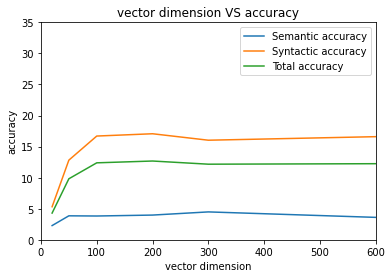

In [959]:
import matplotlib.pyplot as plt
Semantic_d = [2.29, 3.86, 3.83, 3.98, 4.49, 3.61]
Syntactic_d = [5.32, 12.82, 16.70, 17.07, 16.03, 16.6]
Total_d = [4.3, 9.82, 12.39, 12.68, 12.17, 12.25]
vector_dimension = [20, 50, 100, 200, 300, 600]
plt.plot(vector_dimension, Semantic_d,  label='Semantic accuracy')
plt.plot(vector_dimension, Syntactic_d,  label='Syntactic accuracy')
plt.plot(vector_dimension, Total_d, label='Total accuracy')
plt.axis([0, 600, 0, 35])
plt.title('vector dimension VS accuracy')
plt.xlabel('vector dimension')
plt.ylabel('accuracy')
plt.legend()
plt.show()

The window size vs accuracy plot suggests that the accuracy does not change significantly with the change of window size.

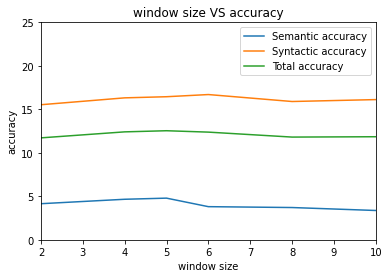

In [960]:
Semantic_w = [4.15, 4.66, 4.79, 3.81, 3.71, 3.37]
Syntactic_w = [15.53, 16.32, 16.45, 16.7, 15.9, 16.12]
Total_w = [11.72, 12.41, 12.54, 12.38, 11.81, 11.85]
window_size = [2, 4, 5, 6, 8, 10]
plt.plot(window_size, Semantic_w,  label='Semantic accuracy')
plt.plot(window_size, Syntactic_w,  label='Syntactic accuracy')
plt.plot(window_size, Total_w, label='Total accuracy')
plt.axis([2, 10, 0, 25])
plt.title('window size VS accuracy')
plt.xlabel('window size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

The min_count vs accuracy plot suggests that the accuracy increases significantly when min_count increases. This shows words with low min_count have less value to the model, some of words might be typo or userID and they appear noise to the model, so a higher min_count value helps model to ignore words with low min_count, get a better understanding of each word, therefore the accuracy is higher.

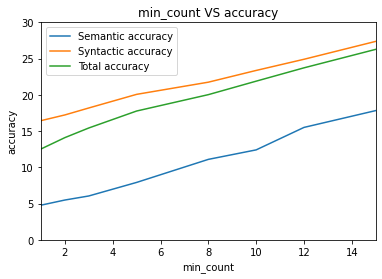

In [961]:
Semantic_m = [4.79, 5.5, 6.06, 7.93, 11.11, 12.42, 15.52, 17.84]
Syntactic_m = [16.45, 17.24, 18.2, 20.08, 21.76, 23.38, 24.92, 27.39]
Total_m = [12.54, 14.11, 15.44, 17.78, 20.04, 21.90, 23.74, 26.29]
min_count = [1,2,3,5,8,10,12,15]
plt.plot(min_count, Semantic_m,  label='Semantic accuracy')
plt.plot(min_count, Syntactic_m,  label='Syntactic accuracy')
plt.plot(min_count, Total_m, label='Total accuracy')
plt.axis([1, 15, 0, 30])
plt.title('min_count VS accuracy')
plt.xlabel('min_count')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## 3.2. Performance Evaluation


The precision, recall, f1-score of both labels are all above 0.99 for the best model. This indicates that the model has good performance on test data.

In [962]:
from sklearn.metrics import classification_report
print(classification_report(test_label, predicted.cpu().numpy(),digits=4))

              precision    recall  f1-score   support

           0     0.9930    0.9930    0.9930      1000
           1     0.9930    0.9930    0.9930      1000

    accuracy                         0.9930      2000
   macro avg     0.9930    0.9930    0.9930      2000
weighted avg     0.9930    0.9930    0.9930      2000



## 3.3. Hyperparameter Testing



With learning rate of 0.01, the f1 score fluctuates up and down with the increase of number of epoch. I believe this is because the learning rate is too large for this model. So the gradient decent jumps left and right of global optim, so that the f1 jumps up and down. And the increase of epoch cannot change this situation, there is no trend between f1 score and number of epoch under this learning rate.

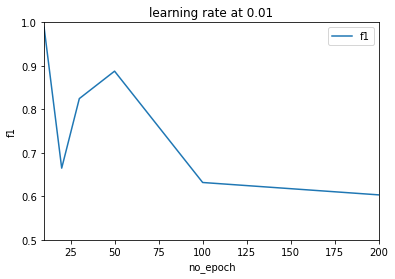

In [963]:
# Please comment your code
f1 = [0.989, 0.665, 0.8249, 0.888, 0.632, 0.6035]
no_epoch = [10,20,30,50,100,200]
plt.plot(no_epoch, f1, label = 'f1')
plt.axis([10, 200, 0.5, 1])
plt.title('learning rate at 0.01')
plt.xlabel('no_epoch')
plt.ylabel('f1')
plt.legend()
plt.show()

With the learning rate of 0.001, the model can achieve above 95% accuracy with only 10 epoches, and 99.7% at 30 epoches, and 99.9% at 100 epoches. The accuracy is already good enough with small number of epoches, so increasing it does not increase accuracy significantly, but increase time and resource need for training the model. Therefore, I set no_epoch is 20 with learning rate 0.001 to get the best model.

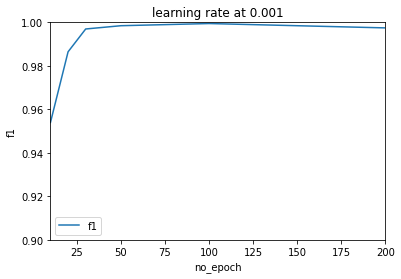

In [964]:
f1 = [0.9540, 0.9865, 0.997, 0.9985, 0.9995, 0.9975]
no_epoch = [10,20,30,50,100,200]
plt.plot(no_epoch, f1, label = 'f1')
plt.axis([10, 200, 0.9, 1])
plt.title('learning rate at 0.001')
plt.xlabel('no_epoch')
plt.ylabel('f1')
plt.legend()
plt.show()

I observe that increasing the sequence of length of input data boosts f1 score in this modol. This can be explained that low sequence of length (that below average length of sentence) cuts too much value of input data, the model does not have enough information for each sentence to perform sentiment analysis, therefore the accuracy can be low. However, a moderate sequence of length, for example in this model I choose 30, can obtain most of information and also cut the unnecessary value to increase the training speed. (considering average length is 11.5 and maximum length is 62)

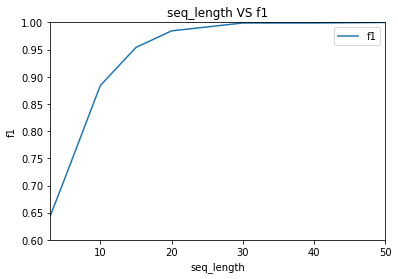

In [965]:
f1 = [0.645, 0.7125, 0.8840, 0.9540, 0.9845, 0.999, 0.999, 1]
seq_length = [3, 5, 10, 15, 20, 30, 40, 50]
plt.plot(seq_length, f1, label = 'f1')
plt.axis([3, 50, 0.6, 1])
plt.title('seq_length VS f1')
plt.xlabel('seq_length')
plt.ylabel('f1')
plt.legend()
plt.show()

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed* 

In [967]:
# If you used OOP style, use this section